In [1]:
%matplotlib inline

In [2]:
from __future__ import division

from matplotlib import  pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from statsmodels.base.model import GenericLikelihoodModel

Рассмотрим примеры оценок ММП. Как и прежде, будем считать, что у нас есть набор независимых одинаково распредленных СВ $X_1, ..., X_n$.

### Распределение Бернулли

Совместная функция плотности для выборки:

$$ f(X_i, p) = p^{X_i}(1-p)^{X_i}.$$

Функция правдоподобия:
$$ L(p) = \prod_{i=1}^{n}p^{X_i}(1-p)^{X_i} = p^{S}(1-p)^{n-S},$$
где $ S = \sum_{i=1}^{n} X_i.$

Перейдем к логарифму:
$$ \ell(p) = S\log(p) + (n-S)\log(1-p).$$

Возьмем производную по $p$:
$\frac{\partial \ell(p)}{\partial p} = \frac{S}{p} - \frac{n-S}{1-p}.$

Отсюда легко получим:
$\hat{p} = \frac{S}{n}$.

### Нормальное распределение

Запишем функцию правдоподобия, опуская константы:
$$ L(\mu, \sigma) = \prod_{i=1}^{n} f(X_i, \mu, \sigma) = \frac{1}{\sigma^n}exp\left( -\frac{1}{2\sigma^2} \sum_{i=1}^{n} (X_i - \mu)^2 \right).$$

Если мы воспользуемся следующим фактом: $\sum_{i=1}^{n} (X_i - \mu)^2 = nS^2 + n(\bar{X}-\mu)^2$ (удостовериться легко: $\sum_{i=1}^{n} (X_i - \mu)^2 = \sum_{i=1}^{n} (X_i - \bar{X} + \bar{X} - \mu)^2 = ...$), то сможем записать в более удобной форме:
$$ L(\mu, \theta) = \sigma^{-n} exp \left( -\frac{nS^2}{2\sigma^2}\right) exp \left( -\frac{n(\bar{X} - \mu)^2}{2\sigma^2}\right).$$

Если мы перейдем к логарифму:
$$ \ell(\mu, \theta) = -n \log\sigma - \frac{nS^2}{2\sigma^2} - \frac{n(\bar{X}-\mu)^2}{2\sigma^2},$$
и разрешить уравнения (приравняв частные производные к нулю), то получим знакомые нам оценки:
$$ \hat{\mu} = \bar{X},$$
$$ \hat{\sigma}^2 = S^2.$$

### Пример: использование ММП для численной оценки параметров

В некоторых областях исследований особый интерес представляют так называемые "zero-inflated models", которые изменяют традиционный закон распределения, позволяя случайной величине принять значение ноль с отличной от "обычной" СВ вероятностью. 

Например - zero-inflated Poisson model. Модель является двупараметрической, с параметрами $\lambda$ - математическим ожиданием распределения Пуассона, и $\pi$ - доля "избыточных" наблюдений со значением 0. 

$$ P(X=0) = \pi + (1-\pi)e^{-\lambda}, $$
$$ P(X=x) = (1-\pi)e^{-\lambda} \frac{\lambda^x}{x!}, x>0. $$

Определим значения параметров:

In [3]:
pi = 0.3
lambda_ = 2.

Функцию вероятности можно записать следующим образом:

In [4]:
def zip_pmf(x, pi=pi, lambda_=lambda_):
    if pi < 0 or pi > 1 or lambda_ <= 0:
        return np.zeros_like(x)
    else:
        return (x == 0) * pi + (1 - pi) * stats.poisson.pmf(x, lambda_)

In [5]:
zip_pmf(0)

0.3947346982656289

In [6]:
stats.poisson.pmf(0, lambda_)

0.1353352832366127

Для сравнения:

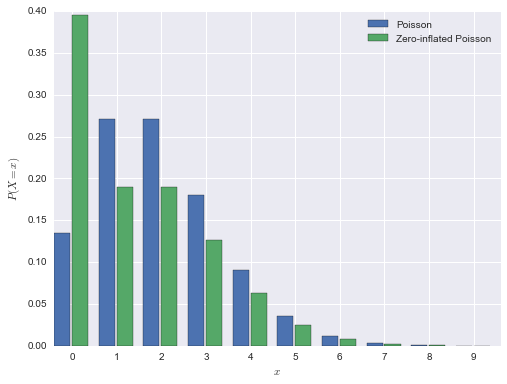

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

xs = np.arange(0, 10);

palette = sns.color_palette()

ax.bar(2.5 * xs, stats.poisson.pmf(xs, lambda_), width=0.9, color=palette[0], label='Poisson');
ax.bar(2.5 * xs + 1, zip_pmf(xs), width=0.9, color=palette[1], label='Zero-inflated Poisson');

ax.set_xticks(2.5 * xs + 1);
ax.set_xticklabels(xs);
ax.set_xlabel('$x$');

ax.set_ylabel('$P(X = x)$');

ax.legend();

Теперь сгенирируем выборку, распределенную по ZIP - закону:

In [8]:
N = 1000
inflated_zero = stats.bernoulli.rvs(pi, size=N)
x = (1 - inflated_zero) * stats.poisson.rvs(lambda_, size=N)

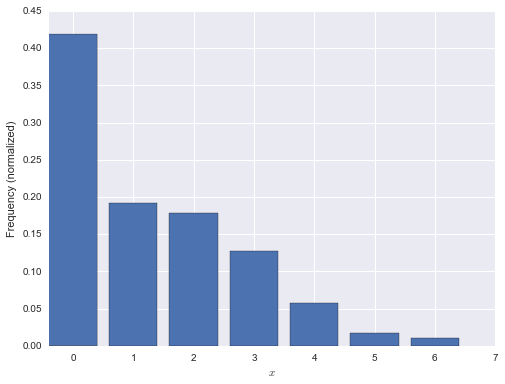

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, width=0.8, bins=np.arange(x.max() + 1), normed=True);

ax.set_xticks(np.arange(x.max() + 1) + 0.4);
ax.set_xticklabels(np.arange(x.max() + 1));
ax.set_xlabel('$x$');

ax.set_ylabel('Frequency (normalized)');

Далее мы воспользуемся statmodels и унаследуем от класса, который позволяет "легко" получать оценки ММП. 

In [10]:
class ZeroInflatedPoisson(GenericLikelihoodModel):
    def __init__(self, endog, exog=None, **kwds):
        if exog is None:
            exog = np.zeros_like(endog)
            
        super(ZeroInflatedPoisson, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        pi = params[0]
        lambda_ = params[1]

        return -np.log(zip_pmf(self.endog, pi=pi, lambda_=lambda_))
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        if start_params is None:
            lambda_start = self.endog.mean()
            excess_zeros = (self.endog == 0).mean() - stats.poisson.pmf(0, lambda_start)
            
            start_params = np.array([excess_zeros, lambda_start])
            
        return super(ZeroInflatedPoisson, self).fit(start_params=start_params,
                                                    maxiter=maxiter, maxfun=maxfun, **kwds)

Что здесь произошло? Мы указали лог-функцию правдоподобия, и в качестве начального приближения для алгоритма минимизации указали долю "избыточных" нулей для $\hat{\pi}$ и выборочное среднее для $\hat{\lambda}$.

In [11]:
model = ZeroInflatedPoisson(x)
results = model.fit()

Optimization terminated successfully.
         Current function value: 1.535895
         Iterations: 39
         Function evaluations: 75


In [12]:
pi_mle, lambda_mle = results.params
pi_mle, lambda_mle

(0.31837121279646818, 1.9130458205991161)